
# Import potrzebnych bibliotek


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, Model, Input #type: ignore
from termcolor import colored
import cv2
SEED = 42

## Dataset

CelebA to duży zbiór obrazów twarzy celebrytów, powszechnie wykorzystywany w badaniach nad rozpoznawaniem i generowaniem cech twarzy. Jego główne atuty to duża liczba próbek, bogate adnotacje atrybutów oraz zróżnicowane warunki (pozycje głowy, tło), co czyni go idealnym do trenowania głębokich modeli generatywnych, takich jak VAE. Na potrzeby tego projektu wykorzystywane będą dane opublikowane na platformie Kaggle ([link](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset))

### Dane wejściowe

- obrazy RGB zapisane w formacie .jpg o wymiarach 178 x 218 (w preprocessingu skalowane do 64 x 64)
- 40 binarnych atrybutów (np. Smiling, Wearing_Hat)
- Obrazy są wstępnie wyrównane i przycięte, zawierają celebrytów w różnych pozach i warunkach oświetleniowych

### Dane wyjściowe

W przypadku kodera:
- reprezentacja obrazu w przestrzeni latentnej

W przypadku dekodera: 
- zrekonstruowane obrazy RGB o wymiarach 178 x 128 (64 x 64)
- wygenerowane nowe obrazy z kontrolowanymi zmianami cech


# Przejrzenie informacji o danych


In [160]:
df_features = pd.read_csv("../data/list_attr_celeba.csv")
num_rows, num_cols = df_features.shape
print(f"Number of rows: {num_rows}, Number of columns: {num_cols}")
df_features.head()

Number of rows: 202599, Number of columns: 41


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


Sprawdzenie rozkładu cech wśród zdjęć. Z tabeli widać że każda cecha przyjmuje wartości -1 lub 1.

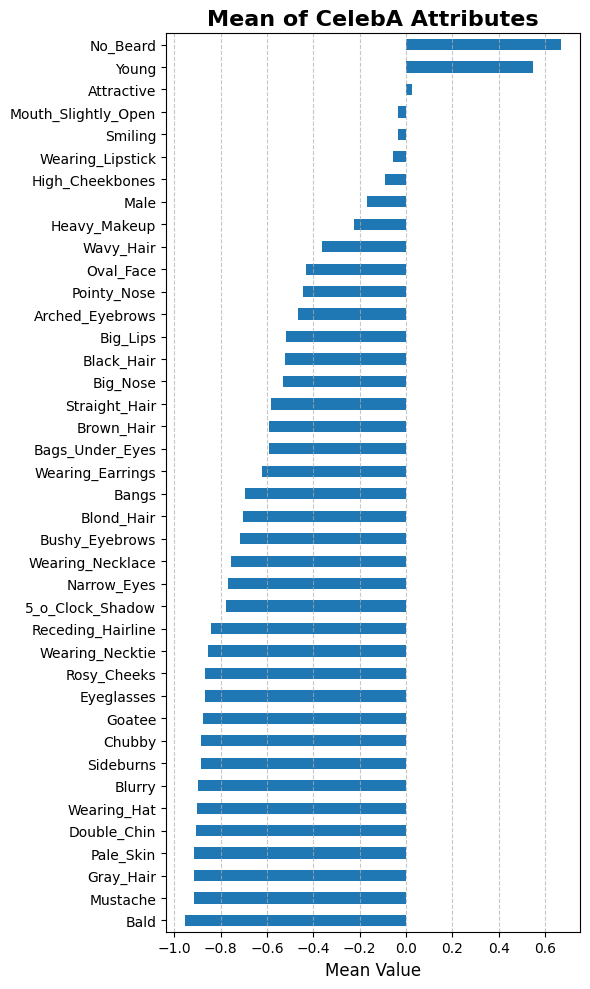

In [161]:
columns = df_features.columns.drop('image_id')
df_features[columns].mean(axis=0).sort_values().plot(kind='barh', figsize=(6, 10))
plt.title("Mean of CelebA Attributes", fontsize=16, fontweight='bold')
plt.xlabel("Mean Value", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Przykładowe zdjęcia ze zbioru

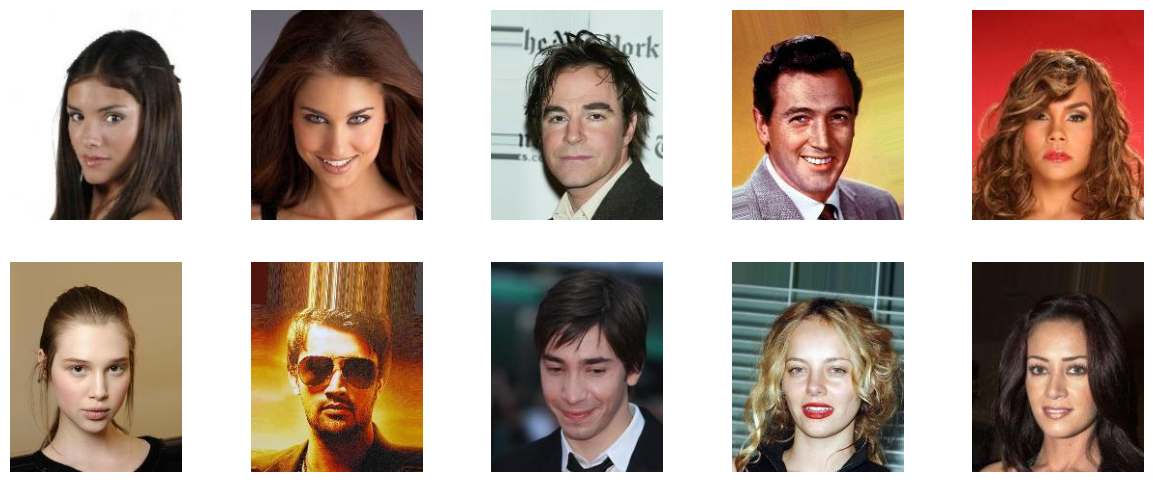

In [ ]:
num_people = 10
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

def generate_imgs(randgen:np.random.default_rng,df:pd.DataFrame,num_people:int,axes:np.ndarray):
    axes = axes.flatten()
    random_indices = randgen.integers(0, df.shape[0], size=num_people)
    formatted_indices = [df.iloc[idx]['image_id'] for idx in random_indices]
    for file,ax in zip(formatted_indices, axes):
        img = plt.imread("../data/img_align_celeba/img_align_celeba/"+file)
        ax.imshow(img)
        ax.axis('off')

generate_imgs(np.random.default_rng(SEED), df_features, num_people, axes)
plt.show()

Przygotowanie pliku csv, który zawiera dobre dane do wycinania twarzy

In [ ]:
df_bbox = pd.read_csv("../data/bbox_celeba.csv")
image_dir = "../data/img_align_celeba/img_align_celeba/"
df_bbox.drop(columns=["x_1","y_1","width","height"], inplace=True)
# Use OpenCV's Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

def get_bbox_distances_cv2(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return [None, None, None, None, 0]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
    if len(faces) == 0:
        return [None, None, None, None, 0]
    (x, y, w, h) = faces[0]
    return [y, x, h, w, 1]

bbox_data = []
i=0
for img_id in df_bbox['image_id']:
    if i%100==0: print(img_id)
    img_path = os.path.join(image_dir, img_id)
    bbox_data.append(get_bbox_distances_cv2(img_path))
    i+=1

df_bbox[['y', 'x', 'h', 'w', 'face_detected']] = pd.DataFrame(bbox_data, index=df_bbox.index)
df_bbox[['image_id','y', 'x', 'h', 'w', 'face_detected']].to_csv("../data/bbox_celeba.csv", index=False)


# Preprocessing danych


Do danych dołączonych jest plik z propozycją podziału zbioru na zbiór treningowy, walidacyjny i testowy. Funkcja ``` make_image_dataset``` przeprowadza wstępną obróbkę danych, na którą składa się: skalowanie do przedziału [0,1], przemieszanie danych, wycinanie twarzy, skalowanie obrazów do rozmiaru 64 x 64 oraz batchowanie. W ostatecznej wersji funkcje te będą znajdowały się w oddzielnym skrypcie *utils.py*.

In [152]:
def make_image_dataset(df,data_path="../data/img_align_celeba/img_align_celeba/",img_size = (64,64),
    batch_size = 64,shuffle= False,buffer_size = 10000):
    """
    Returns a tf.data.Dataset yielding batches of normalized images.
    """
    files = df['image_id'].tolist()
    bboxes = df[['y', 'x', 'h', 'w']].values.astype(np.int32)
    ds = tf.data.Dataset.from_tensor_slices((files, bboxes))
    if shuffle:
        ds = ds.shuffle(buffer_size)

    def _load_and_preprocess(path, bbox):
        path = tf.strings.join([data_path, path])
        # Read raw bytes
        raw = tf.io.read_file(path)
        # Decode JPEG, force RGB
        img = tf.image.decode_jpeg(raw, channels=3)
        # Normalize to [0,1]
        img = tf.cast(img, tf.float32) / 255.0
        # Crop and resize to target size
        img = tf.image.crop_to_bounding_box(img, bbox[0], bbox[1], bbox[2], bbox[3])
        img = tf.image.resize(img, img_size)
        return img
    # Map and prefetch
    ds = ds.map(_load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size,drop_remainder=True)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

Sprawdzenie poprawności ładowania danych


************ Summary ************



  0%|          | 0/2418 [00:00<?, ?it/s]

Examples/sec (First included) 4269.10 ex/sec (total: 154816 ex, 36.26 sec)
Examples/sec (First only) 489.53 ex/sec (total: 64 ex, 0.13 sec)
Examples/sec (First excluded) 4282.78 ex/sec (total: 154752 ex, 36.13 sec)
Batch shape: (64, 64, 64, 3)


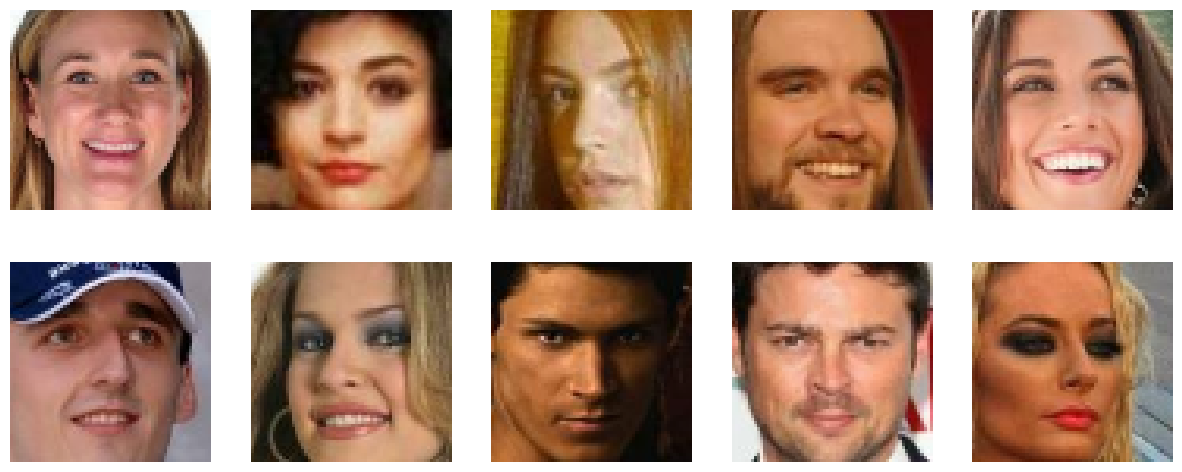

In [179]:
csv_path  = '../data/list_eval_partition.csv'
bbox_path = '../data/bbox_celeba.csv'
image_dir = '../data/img_align_celeba/img_align_celeba/'
BATCH_SIZE = 64

df_partition = pd.read_csv(csv_path)
df_data = pd.read_csv(bbox_path)
df = pd.merge(df_data, df_partition, on='image_id')
face_filter = df["face_detected"] == 1
df = df[face_filter].drop(columns=["face_detected"])

df_train = df[df["partition"] == 0].drop(columns=["partition"])
df_val = df[df["partition"] == 1].drop(columns=["partition"])
df_test = df[df["partition"] == 2].drop(columns=["partition"])

train_ds = make_image_dataset(df_train,image_dir,img_size=(64,64),batch_size=BATCH_SIZE,shuffle=True)
val_ds = make_image_dataset(df_val,image_dir,img_size=(64,64),batch_size=BATCH_SIZE)
test_ds = make_image_dataset(df_test,image_dir,img_size=(64,64),batch_size=BATCH_SIZE)

tfds.benchmark(train_ds,batch_size=BATCH_SIZE)

for batch in train_ds.take(1):
    print("Batch shape:", batch.shape)
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    idx = np.random.choice(np.arange(0, 64), size=10, replace=False)
    for i, ax in zip(idx, axes):
        img = tf.keras.utils.array_to_img(batch[i],data_format="channels_last",scale=True)
        ax.imshow(img)
        ax.axis('off')

Wybieranie obrazów z konkretną cechą

C:\Users\przem\AppData\Local\Temp\ipykernel_8236\3860028110.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_features = df_features[face_filter]


Batch shape: (64, 64, 64, 3)


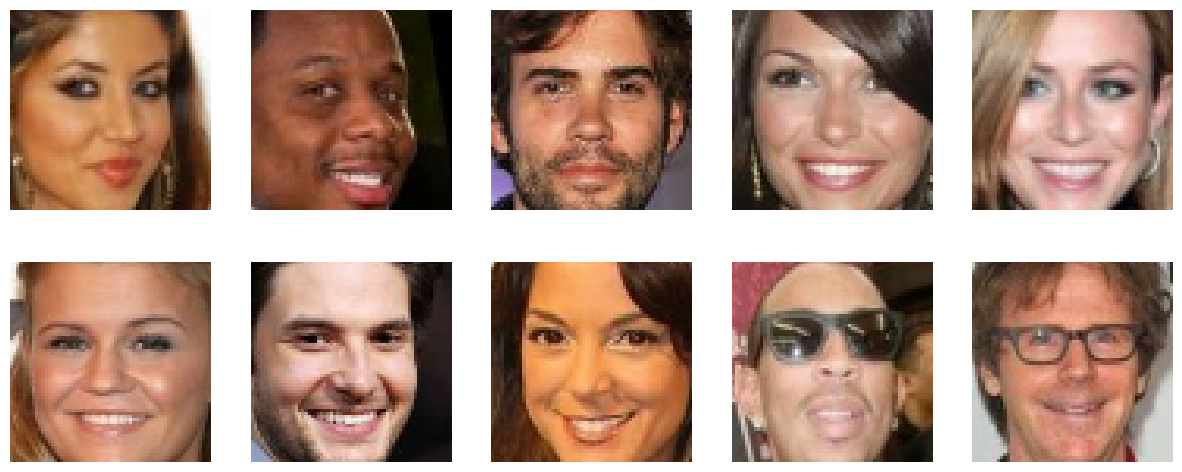

In [180]:
FEATURE = 'Smiling'

df_features = df_features[face_filter]
smile_filter = df_features[FEATURE]==1
df_smile = df[smile_filter]

smile_ds = make_image_dataset(df_smile,image_dir,img_size=(64,64),batch_size=BATCH_SIZE,shuffle=True)

for batch in smile_ds.take(1):
    print("Batch shape:", batch.shape)
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    idx = np.random.choice(np.arange(0, 64), size=10, replace=False)
    for i, ax in zip(idx, axes):
        img = tf.keras.utils.array_to_img(batch[i],data_format="channels_last",scale=True)
        ax.imshow(img)
        ax.axis('off')


# Przewidywana architektura modelu


In [154]:
BATCH_SIZE = 64
latent_dim = 256  # wymiar przestrzeni latentnej

In [155]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=(BATCH_SIZE, latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [156]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder,beta=0.1, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return z_mean,z_log_var,reconstructed
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstructed = self(data)

            kl_loss = -0.5 * tf.reduce_mean(
                z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
            )
            reconstruction_loss = tf.reduce_mean(
                    #tf.keras.losses.binary_crossentropy(data, reconstructed)
                    tf.keras.losses.MeanSquaredError()(data,reconstructed)
                    
            )
            total_loss = self.beta * kl_loss + reconstruction_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss":total_loss,"kl_loss": kl_loss, "reconstruction_loss": reconstruction_loss}
    def test_step(self,data):
        z_mean, z_log_var, reconstructed = self(data)
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        reconstruction_loss = tf.reduce_mean(
            #tf.keras.losses.binary_crossentropy(data, reconstructed)
            tf.keras.losses.MeanSquaredError()(data,reconstructed)
        )
        total_loss = self.beta * kl_loss + reconstruction_loss
        return {"loss":total_loss,"kl_loss": kl_loss, "reconstruction_loss": reconstruction_loss}

In [157]:
print(colored("Encoder:","red"))
encoder_inputs = Input(shape=(64, 64, 3), name="encoder_input")  
x = layers.Conv2D(32, kernel_size=5, strides=2, padding="same", activation="relu")(encoder_inputs)
x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same", activation="relu")(x)
x = layers.Conv2D(64, kernel_size=3, strides=1, padding="same", activation="relu")(x)
x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same", activation="relu")(x)
x = layers.Flatten()(x)
z_mean    = layers.Dense(latent_dim, name="z_mean")(x)      
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean,z_log_var,z], name="encoder")
z_predict = encoder.predict(train_ds.take(1))
print(colored("Test prediction shape of 1 batch:","blue"),z_predict[0].shape)
encoder.summary()

Encoder:
1/1 [==============================] - 0s 166ms/step
Test prediction shape of 1 batch: (64, 256)
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 32, 32, 32)           2432      ['encoder_input[0][0]']       
                                                                                                  
 conv2d_5 (Conv2D)           (None, 16, 16, 64)           18496     ['conv2d_4[0][0]']            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 16, 16, 64)           36928     ['conv2d_5[0][0]'

In [158]:
print(colored("Decoder:","red"))
decoder_input = Input(shape=(latent_dim,), name="z_input")
x = layers.Dense(8 * 8 * latent_dim, activation="relu")(decoder_input)
x = layers.Reshape((8, 8, latent_dim))(x)
x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(64,  kernel_size=3, strides=1, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(64,  kernel_size=3, strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(32,  kernel_size=5, strides=2, padding="same", activation="relu")(x)
decoder_output = layers.Conv2DTranspose(
        3, kernel_size=3, strides=1, padding="same", activation="sigmoid", name="decoder_output")(x)
decoder = Model(decoder_input, decoder_output, name="conv_decoder")
predict = decoder.predict(z_predict[2])
print(colored("Test prediction shape of 1 batch:","blue"),predict.shape)
decoder.summary()

Decoder:
2/2 [==============================] - 0s 39ms/step
Test prediction shape of 1 batch: (64, 64, 64, 3)
Model: "conv_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_input (InputLayer)        [(None, 256)]             0         
                                                                 
 dense_1 (Dense)             (None, 16384)             4210688   
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 16, 16, 64)        147520    
 Transpose)                                                      
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 16, 16, 64)        36928     
 Transpose)                                                      
         

In [159]:
vae = VAE(encoder, decoder,beta=0.05)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
vae.fit(train_ds.take(1), epochs=1, validation_data=train_ds.take(1), verbose=1)

1/1 [==============================] - 2s 2s/step - loss: 0.0706 - kl_loss: 0.0018 - reconstruction_loss: 0.0705 - val_loss: 0.0705 - val_kl_loss: 0.0014 - val_reconstruction_loss: 0.0705
